# Практичні завдання з аналізу часових рядів

У цьому ноутбуці ми виконаємо практичні завдання з аналізу та прогнозування часових рядів, використовуючи різні методи машинного навчання.

In [2]:
%pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/5e/03/15cd49e855c62226ecf1831bbe4c8e73a4324856077a23c495538a36e557/xgboost-3.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/150.0 MB 3.2 MB/s eta 0:00:47
   ---------------------------------------- 0.6/150.0 MB 5.8 MB/s eta 0:00:26
   ---------------------------------------- 1.2/150.0 MB 6.2 MB/s eta 0:00:25
   ---------------------------------------- 1.3/150.0 MB 6.7 MB/s eta 0:00:23
    --------------------------------------- 2.3/150.0 MB 8.2 MB/s eta 0:00:18
    --------------------------------------- 2.9/150.0 MB 8.8 MB/s eta 0:00:17
    --------------------------------------- 3.3/150.0 MB 8.8 MB/s eta 0:00:17
   - -------------------------------------- 3.8/150.0 MB 8.9 MB/s eta 0:00:17
   - -------------------------------------- 4.6/150.0 MB 9.0 MB/s eta 0:00:17
   - -----------------


[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Імпорт необхідних бібліотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Налаштування для графіків
plt.style.use('seaborn-v0_8')
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

## Завдання 1: Підготовка та аналіз даних

У цьому завданні ми завантажимо дані часового ряду, проведемо їх очищення, аналіз та підготовку для подальшого моделювання.

In [5]:
# Завантаження даних
df = pd.read_csv('time_series_data.csv')

# Перетворення стовпця з датами у формат datetime
df['date'] = pd.to_datetime(df['date'])

# Встановлення дати як індексу
df.set_index('date', inplace=True)

# Виведення перших рядків даних
print('Перші 5 рядків даних:')
display(df.head())

# Перевірка на пропущені значення
print('Кількість пропущених значень:')
display(df.isna().sum())

# Основні статистичні показники
print('Статистичні показники:')
display(df.describe())


Перші 5 рядків даних:


,value
date,
2020-01-01,0.496714
2020-01-02,0.253761
2020-01-03,1.429593
2020-01-04,2.690532
2020-01-05,1.312556


Кількість пропущених значень:


value    20
dtype: int64

Статистичні показники:


,value
count,980.000000
mean,7.561487
std,5.511649
min,-5.245756
25%,3.654858
50%,7.668896
75%,11.484155
max,20.425943


Кількість пропущених значень до заповнення:
value    20
dtype: int64
Кількість пропущених значень після заповнення:
value    0
dtype: int64


C:\Users\Александр\AppData\Local\Temp\ipykernel_18336\2212484670.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['value'] = df['value'].fillna(method='ffill')


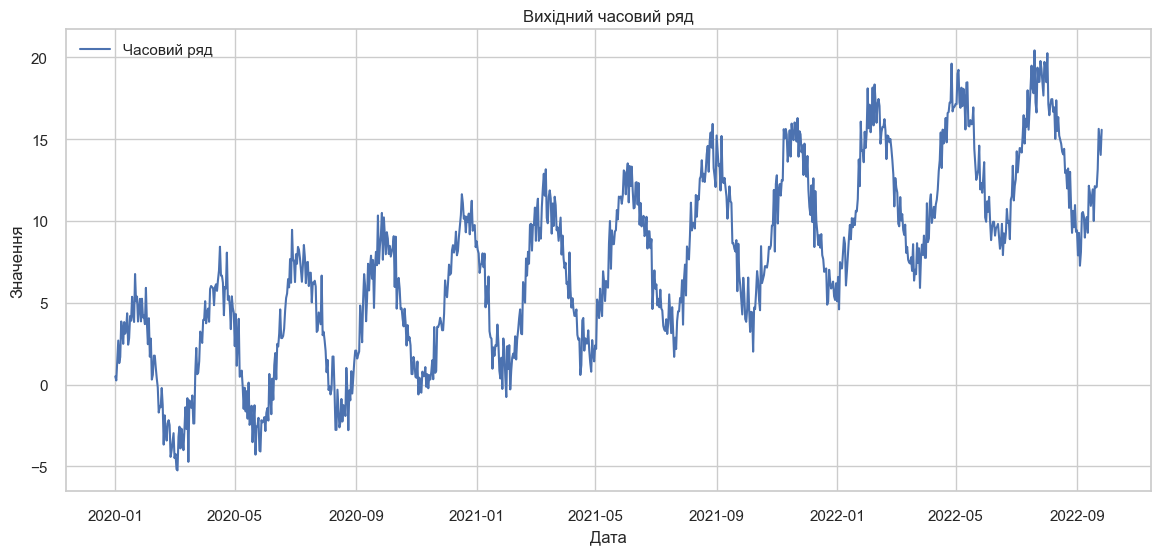

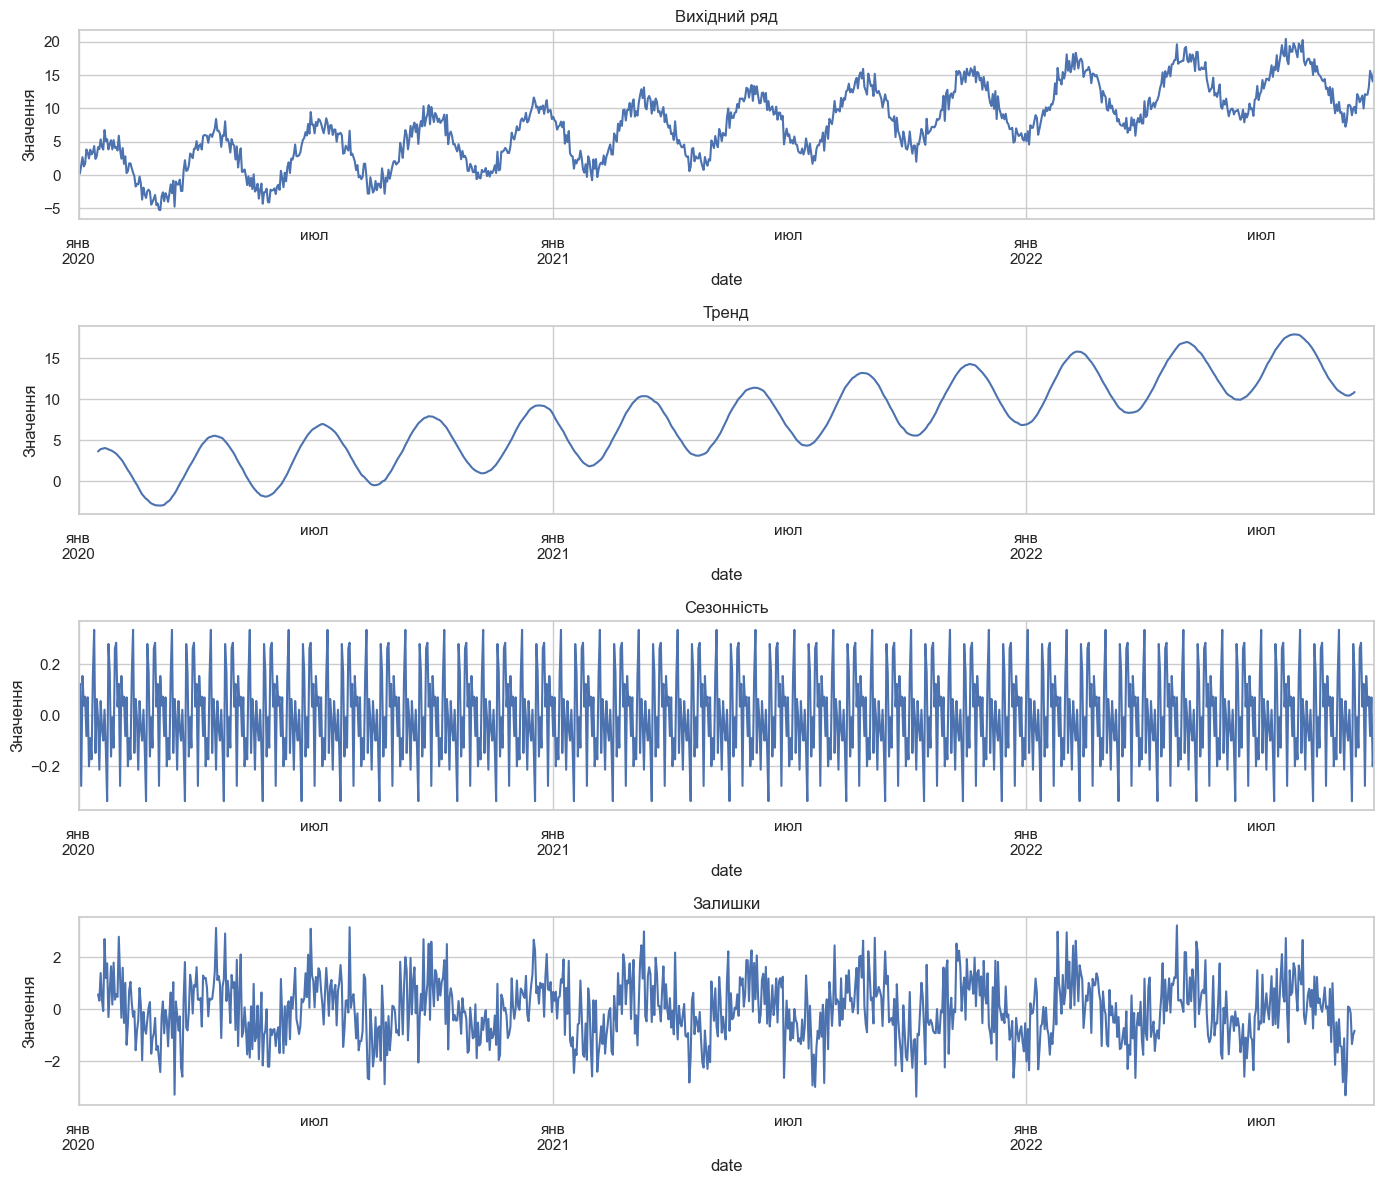

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Завантаження даних
df = pd.read_csv('time_series_data.csv')

# Перетворення дати та встановлення індексу
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Перевірка пропущених значень
print('Кількість пропущених значень до заповнення:')
print(df.isna().sum())

# Заповнення пропущених значень методом "forward fill"
df['value'] = df['value'].fillna(method='ffill')

print('Кількість пропущених значень після заповнення:')
print(df.isna().sum())

# Візуалізація часового ряду
plt.figure(figsize=(14, 6))
plt.plot(df['value'], label='Часовий ряд')
plt.title('Вихідний часовий ряд')
plt.xlabel('Дата')
plt.ylabel('Значення')
plt.legend()
plt.grid(True)
plt.show()

# Декомпозиція часового ряду
decomposition = seasonal_decompose(df['value'], model='additive', period=30)

# Візуалізація результатів декомпозиції
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))

decomposition.observed.plot(ax=ax1)
ax1.set_title('Вихідний ряд')
ax1.set_ylabel('Значення')

decomposition.trend.plot(ax=ax2)
ax2.set_title('Тренд')
ax2.set_ylabel('Значення')

decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Сезонність')
ax3.set_ylabel('Значення')

decomposition.resid.plot(ax=ax4)
ax4.set_title('Залишки')
ax4.set_ylabel('Значення')

plt.tight_layout()
plt.show()


In [8]:
# Нормалізація даних
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Створення функції для підготовки даних для часових рядів
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Визначення довжини послідовності (кількість днів для прогнозування)
seq_length = 30  # 30 днів для прогнозування наступного дня

# Створення послідовностей
X, y = create_sequences(df_scaled, seq_length)

# Розділення на тренувальну та тестову вибірки (80% / 20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Форма тренувальних даних: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Форма тестових даних: X_test: {X_test.shape}, y_test: {y_test.shape}')

Форма тренувальних даних: X_train: (776, 30, 1), y_train: (776, 1)
Форма тестових даних: X_test: (194, 30, 1), y_test: (194, 1)


## Завдання 2: Прогнозування за допомогою XGBoost

У цьому завданні ми використаємо алгоритм XGBoost для прогнозування часового ряду на наступний місяць.

In [9]:
# Підготовка даних для XGBoost (перетворення 3D масиву в 2D)
X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_2d = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Створення та навчання моделі XGBoost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train_2d, y_train)

# Прогнозування
y_pred_xgb = model_xgb.predict(X_test_2d)

# Перетворення назад до оригінального масштабу
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_xgb_inv = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1)).flatten()

# Оцінка якості прогнозу
mse_xgb = mean_squared_error(y_test_inv, y_pred_xgb_inv)
mae_xgb = mean_absolute_error(y_test_inv, y_pred_xgb_inv)

print(f'XGBoost MSE: {mse_xgb:.4f}')
print(f'XGBoost MAE: {mae_xgb:.4f}')

XGBoost MSE: 3.3237
XGBoost MAE: 1.4404


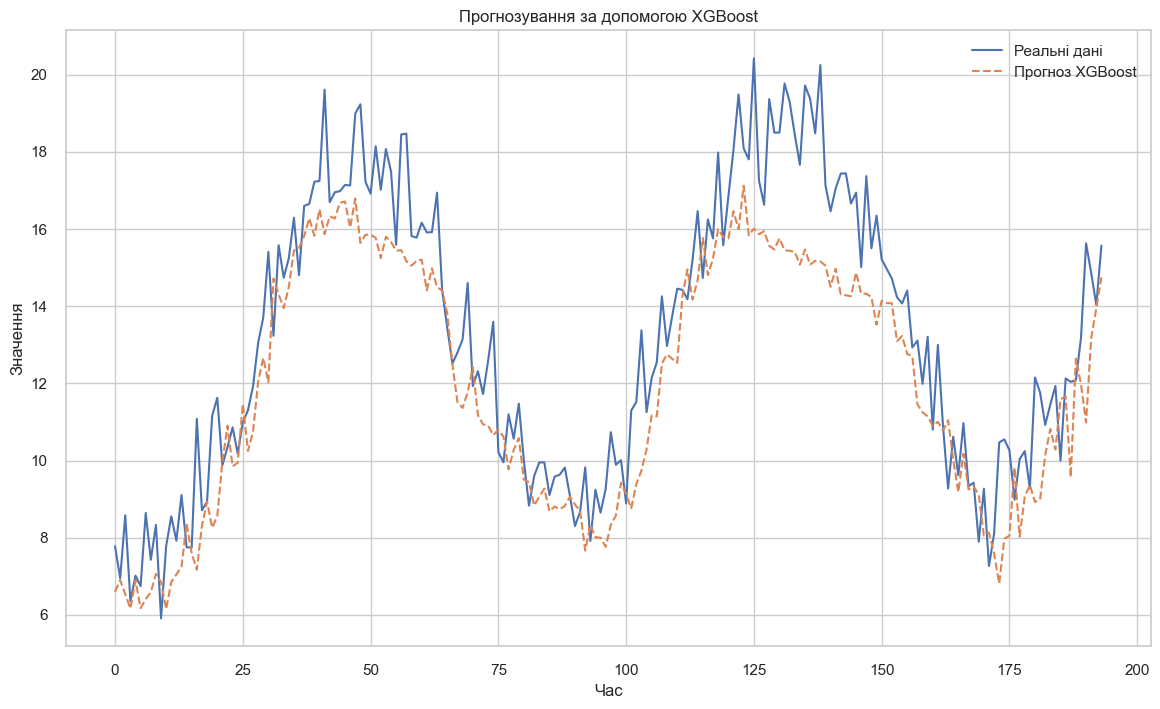

<Figure size 1200x600 with 0 Axes>

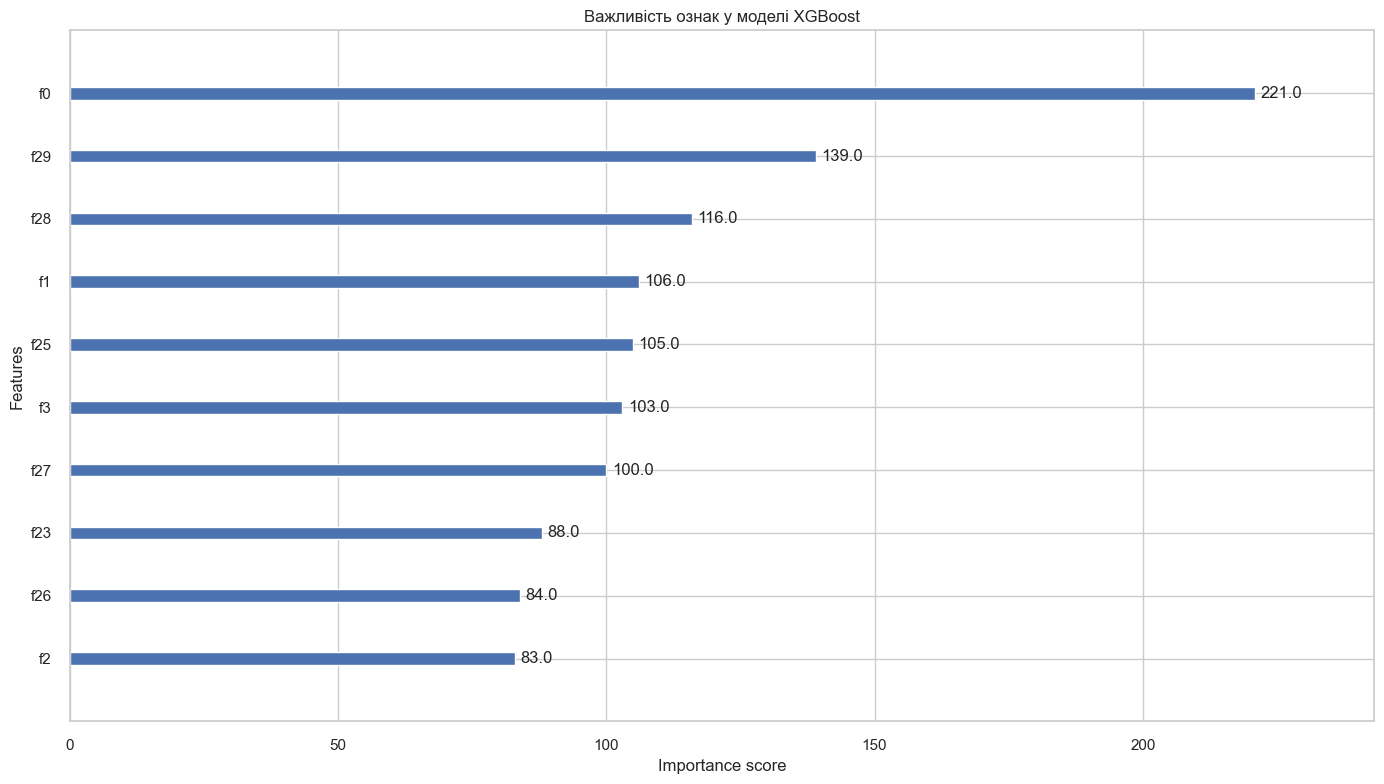

In [10]:
# Візуалізація результатів XGBoost
plt.figure(figsize=(14, 8))
plt.plot(y_test_inv, label='Реальні дані')
plt.plot(y_pred_xgb_inv, label='Прогноз XGBoost', linestyle='dashed')
plt.title('Прогнозування за допомогою XGBoost')
plt.xlabel('Час')
plt.ylabel('Значення')
plt.legend()
plt.grid(True)
plt.show()

# Аналіз важливості ознак
plt.figure(figsize=(12, 6))
xgb.plot_importance(model_xgb, max_num_features=10)
plt.title('Важливість ознак у моделі XGBoost')
plt.tight_layout()
plt.show()

## Завдання 3: Побудова та навчання LSTM-моделі

У цьому завданні ми побудуємо та навчимо модель LSTM (Long Short-Term Memory) для прогнозування часового ряду.

In [15]:
# Перетворення даних для LSTM (потрібен 3D масив: [зразки, часові кроки, ознаки])
X_train_3d = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_3d = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Створення моделі LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

# Компіляція моделі
model_lstm.compile(optimizer='adam', loss='mse')

# Навчання моделі без ранньої зупинки
history_lstm = model_lstm.fit(
    X_train_3d, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.1, 
    # callbacks=[early_stopping],  # ← закоментовано
    verbose=1
)


# Навчання моделі
history_lstm = model_lstm.fit(
    X_train_3d, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.1, 
    callbacks=[early_stopping], 
    verbose=1
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0973 - val_loss: 0.0408
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0140 - val_loss: 0.0226
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0080 - val_loss: 0.0057
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0053 - val_loss: 0.0082
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0046 - val_loss: 0.0085
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0049 - val_loss: 0.0067
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0055 - val_loss: 0.0074
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0

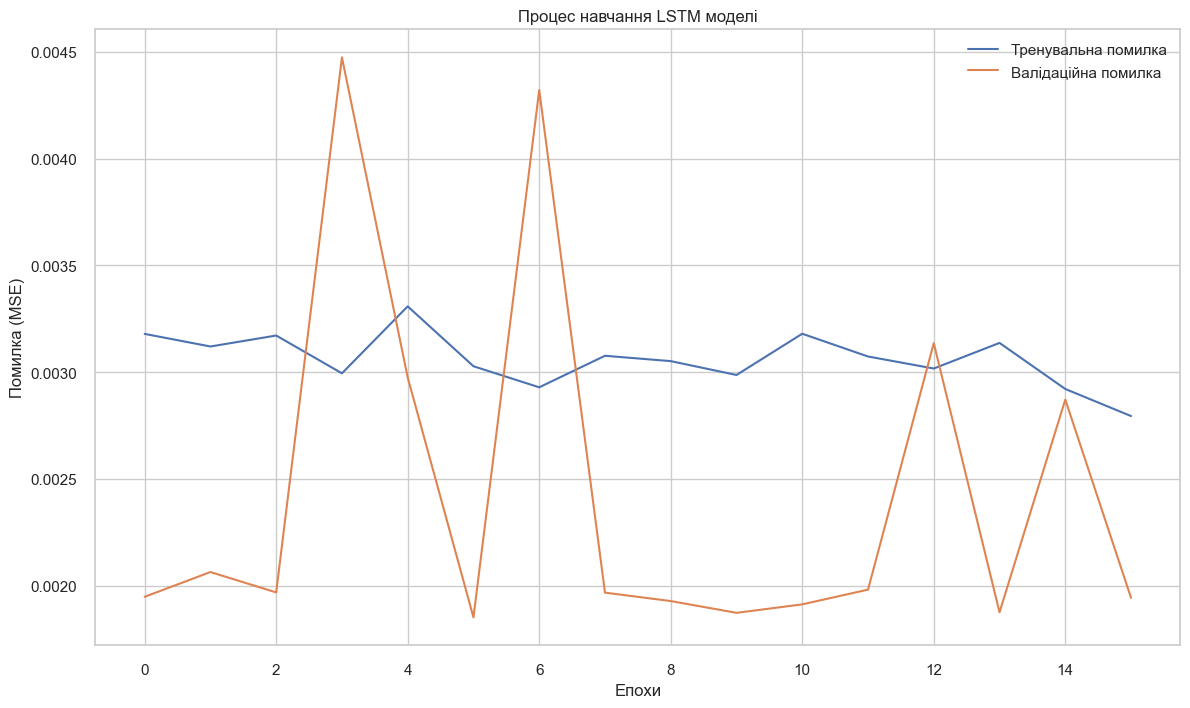

In [16]:
# Візуалізація процесу навчання LSTM
plt.figure(figsize=(14, 8))
plt.plot(history_lstm.history['loss'], label='Тренувальна помилка')
plt.plot(history_lstm.history['val_loss'], label='Валідаційна помилка')
plt.title('Процес навчання LSTM моделі')
plt.xlabel('Епохи')
plt.ylabel('Помилка (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Прогнозування за допомогою LSTM
y_pred_lstm = model_lstm.predict(X_test_3d)

# Перетворення назад до оригінального масштабу
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm).flatten()

# Оцінка якості прогнозу LSTM
mse_lstm = mean_squared_error(y_test_inv, y_pred_lstm_inv)
mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm_inv)

print(f'LSTM MSE: {mse_lstm:.4f}')
print(f'LSTM MAE: {mae_lstm:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
LSTM MSE: 1.2070
LSTM MAE: 0.8657


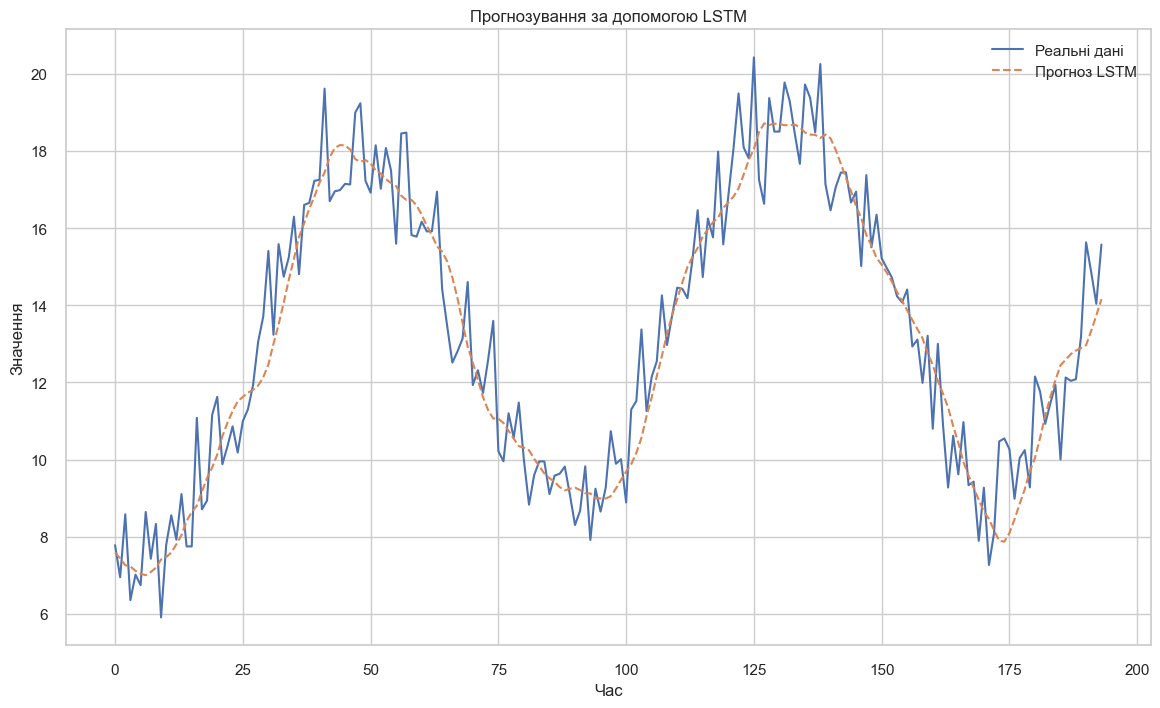

In [18]:
# Візуалізація результатів LSTM
plt.figure(figsize=(14, 8))
plt.plot(y_test_inv, label='Реальні дані')
plt.plot(y_pred_lstm_inv, label='Прогноз LSTM', linestyle='dashed')
plt.title('Прогнозування за допомогою LSTM')
plt.xlabel('Час')
plt.ylabel('Значення')
plt.legend()
plt.grid(True)
plt.show()

## Завдання 4: Порівняння результатів моделей

У цьому завданні ми порівняємо результати прогнозування різних моделей та зробимо висновки щодо їх ефективності.

,Модель,MSE,MAE
0,XGBoost,3.323689,1.440375
1,LSTM,1.206998,0.865710


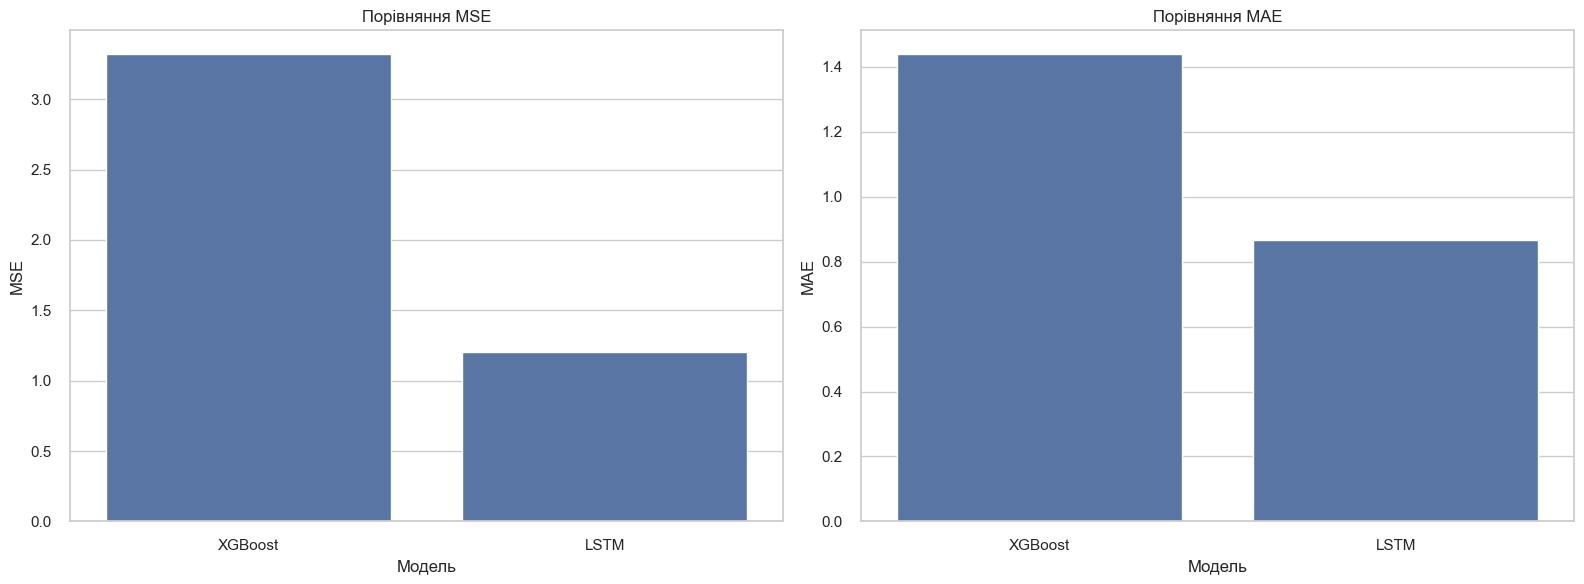

In [19]:
# Порівняння метрик якості моделей
metrics = {
    'Модель': ['XGBoost', 'LSTM'],
    'MSE': [mse_xgb, mse_lstm],
    'MAE': [mae_xgb, mae_lstm]
}

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

# Візуалізація порівняння метрик
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x='Модель', y='MSE', data=metrics_df, ax=ax1)
ax1.set_title('Порівняння MSE')
ax1.set_ylabel('MSE')

sns.barplot(x='Модель', y='MAE', data=metrics_df, ax=ax2)
ax2.set_title('Порівняння MAE')
ax2.set_ylabel('MAE')

plt.tight_layout()
plt.show()

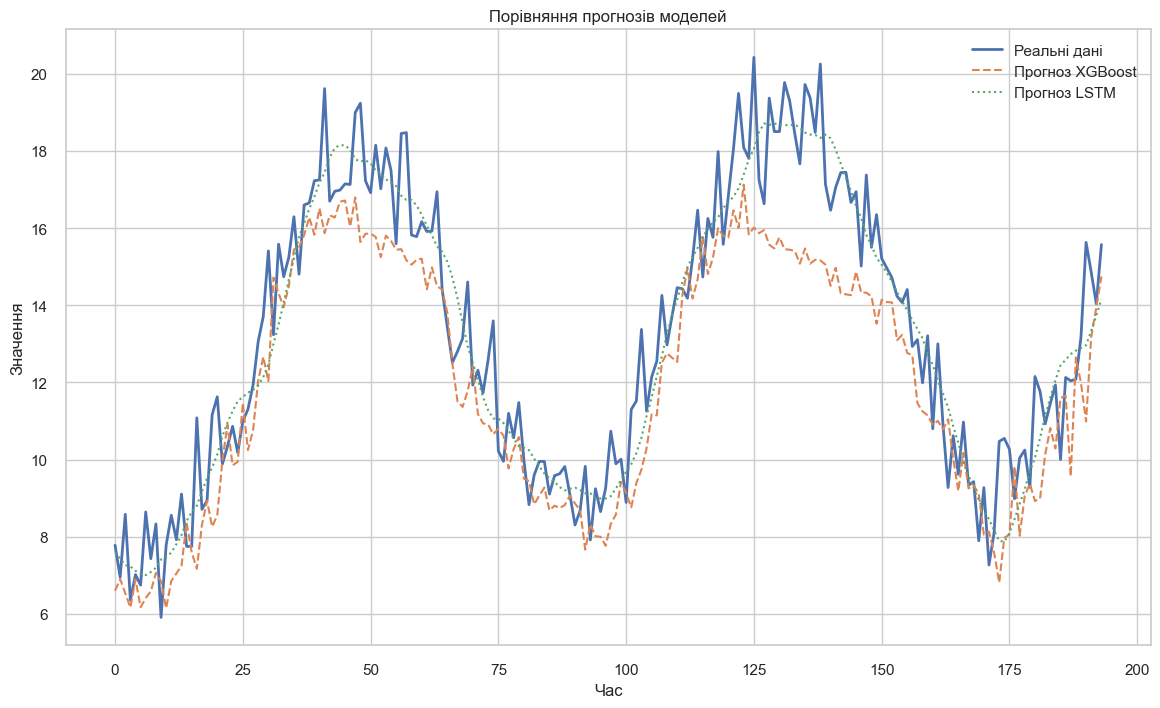

In [20]:
# Візуалізація прогнозів обох моделей
plt.figure(figsize=(14, 8))
plt.plot(y_test_inv, label='Реальні дані', linewidth=2)
plt.plot(y_pred_xgb_inv, label='Прогноз XGBoost', linestyle='dashed')
plt.plot(y_pred_lstm_inv, label='Прогноз LSTM', linestyle='dotted')
plt.title('Порівняння прогнозів моделей')
plt.xlabel('Час')
plt.ylabel('Значення')
plt.legend()
plt.grid(True)
plt.show()

## Висновки

У цьому практичному завданні ми виконали наступні кроки:

1. **Підготовка даних**: Завантажили, очистили та нормалізували дані часового ряду, провели аналіз на наявність тренду та сезонності.

2. **Прогнозування за допомогою XGBoost**: Побудували модель XGBoost для прогнозування часового ряду на наступний місяць, оцінили її якість.

3. **Побудова LSTM-моделі**: Створили та навчили модель LSTM для прогнозування часового ряду, проаналізували процес навчання.

4. **Порівняння результатів**: Порівняли результати прогнозування різних моделей за метриками MSE та MAE.

Основні висновки:

- Обидві моделі показали здатність прогнозувати часовий ряд, але з різною точністю.
- LSTM-модель краще враховує довгострокові залежності в даних, що може бути корисним для складних часових рядів.
- XGBoost має перевагу в швидкості навчання та простоті реалізації.
- Вибір моделі залежить від конкретної задачі та характеристик часового ряду.